In [3]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, get_gldas_land_mask

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

In [4]:
from deepsensor.active_learning.acquisition_fns import MeanStddev
from deepsensor.active_learning import GreedyAlgorithm

In [5]:
# Training/data config
data_range = ("2018-01-01", "2019-03-31")
train_range = ("2018-01-01", "2018-12-31")
val_range = ("2019-01-01", "2019-03-31")
date_subsample_factor = 2
extent = "north_america"
era5_var_IDs = ["2m_temperature"]
lowres_auxiliary_var_IDs = ["elevation"]
cache_dir = "mycache"
deepsensor_folder = "deepsensor_config/"
verbose_download = True

In [6]:
lowres_aux_raw_ds = get_earthenv_auxiliary_data(lowres_auxiliary_var_IDs, extent, "100KM", cache=True, cache_dir=cache_dir, verbose=verbose_download)
land_mask_raw_ds = get_gldas_land_mask(extent, cache=True, cache_dir=cache_dir, verbose=verbose_download)
era5_raw_ds = get_era5_reanalysis_data(era5_var_IDs, extent, date_range=data_range, cache=True, cache_dir=cache_dir, verbose=verbose_download, num_processes=8)

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds = data_processor(era5_raw_ds, method="min_max")
lowres_aux_ds, land_mask_ds = data_processor([lowres_aux_raw_ds, land_mask_raw_ds], method="min_max")

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
lowres_aux_ds["cos_D"] = doy_ds["cos_D"]
lowres_aux_ds["sin_D"] = doy_ds["sin_D"]

100%|██████████| 15/15 [00:00<00:00, 68.24it/s]


0.18 GB loaded in 0.33 s


In [7]:
print(data_processor)

DataProcessor with normalisation params:
{'2m_temperature': {'method': 'min_max',
                    'params': {'max': 314.31219482421875,
                               'min': 219.44639587402344}},
 'GLDAS_mask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (15.0, 115.0), 'name': 'lat'},
            'x2': {'map': (-160.0, -60.0), 'name': 'lon'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 3228.330810546875,
                          'min': -6.24999984211172e-06}}}


In [8]:
# task_loader = TaskLoader(
#     context=[era5_ds, land_mask_ds, lowres_aux_ds],
#     target=era5_ds,
# )
# task_loader.load_dask()
# print(task_loader)

In [9]:
# Converting to dataframe for easier wokring
era5_ds_df = era5_ds.to_dataframe()

# Randomly taking some 50 lat-long locations as initial sensor placement
lat_long_pairs = era5_ds[['x1','x2']].to_dataframe().reset_index().sample(n=50).to_numpy()

# Initial sensor location data
Initial_sensor_locations = pd.merge(era5_ds_df.reset_index(),pd.DataFrame(lat_long_pairs,columns=['x1','x2']), on =['x1','x2'],how='inner').set_index(['time','x1','x2'])

In [10]:
# task_loader_train = TaskLoader(
#     context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
#     target=era5_ds,
# )
# task_loader_train.load_dask()
# print(task_loader_train)

# print()

# task_loader_val = TaskLoader(
#     context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
#     target=era5_ds,
# )
# task_loader_val.load_dask()
# print(task_loader_val)

In [11]:
def gen_tasks(dates,task_loader, progress = True):
    tasks = []
    for date in tqdm_notebook(dates, disable = not progress):
        task = task_loader(date, context_sampling=['all', "all", "all"], target_sampling="all")
        tasks.append(task)
    return tasks

def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = "2m_temperature"
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task),target_var_ID, unnorm= True)
        true = data_processor.map_array(task["Y_t"][0],target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors)**2))

def compute_std(model,val_tasks):
    stds = []
    for task in val_tasks:
        pred = model.predict(task, X_t=era5_raw_ds)
        stds.append(pred['2m_temperature']['std'].to_dataframe().mean()[0])

    return np.mean(stds)

def train_model(model,train_tasks,val_tasks=None,epochs=5):
    losses = []
    val_rmses = []
    stds =  []
    trainer = Trainer(model, lr = 5e-5)
    for epoch in tqdm_notebook(range(epochs)):
        
        batch_losses = trainer(train_tasks)

        if val_tasks:
            losses.append(np.mean(batch_losses))
            val_rmses.append(compute_val_rmse(model,val_tasks))
            stds.append(compute_std(model,val_tasks))
            print("Epoch {} | Error {:.2f} | std {:.2f}".format(epoch+1,val_rmses[-1],stds[-1]))

In [12]:
# # initializing train dates
# train_dates = pd.date_range(train_range[0],train_range[1])[::2]
# train_tasks = gen_tasks(train_dates,task_loader_train)

# # initialzing val dates
# # val_dates = pd.date_range(val_range[0], val_range[1])
# val_dates = [pd.to_datetime(val_range[0])]
# val_tasks = gen_tasks(val_dates,task_loader_val)

In [13]:


# greedy_alg = GreedyAlgorithm(
#     model=model,
#     X_t=era5_raw_ds,
#     X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
#     X_s_mask=land_mask_raw_ds,  # Mask out ocean from search points
#     X_t_mask=land_mask_raw_ds,  # Mask out ocean from target points
#     N_new_context=1,
#     progress_bar=True,
# )

In [17]:

task_loader_train = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_train.load_dask()
print(task_loader_train)

print()

task_loader_val = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_val.load_dask()
print(task_loader_val)


# set up model 
model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))

# initializing train dates
train_dates = pd.date_range(train_range[0],train_range[1])[::2]
train_tasks = gen_tasks(train_dates,task_loader_train)

# initialzing val dates
# val_dates = pd.date_range(val_range[0], val_range[1])
val_dates = [pd.to_datetime(val_range[0])]
val_tasks = gen_tasks(val_dates,task_loader_val)

initial_rmse = compute_val_rmse(model,val_tasks)
initial_std = compute_std(model,val_tasks)

print(initial_rmse)
print(initial_std)

lat_long_pairs_current = lat_long_pairs.copy()
current_sensor_locations = Initial_sensor_locations.copy()

train_model(model,train_tasks,val_tasks)

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=land_mask_raw_ds,  # Mask out ocean from search points
    X_t_mask=land_mask_raw_ds,  # Mask out ocean from target points
    N_new_context=1,
    progress_bar=True,
)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)
dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

30.64563
54.92167


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Error 14.01 | std 15.25
Epoch 2 | Error 16.90 | std 19.66
Epoch 3 | Error 10.54 | std 12.35
Epoch 4 | Error 9.44 | std 8.51
Epoch 5 | Error 8.97 | std 9.40


In [18]:
vars = []
max_points_to_pick = 5
lat_long_pairs_current = lat_long_pairs.copy()

# initial_rmse = compute_val_rmse(model,val_tasks)
# initial_std = compute_std(model,val_tasks)

MeanStddev_rmse = [initial_rmse]
MeanStddev_std = [initial_rmse]

for iter in tqdm_notebook(range(max_points_to_pick)):

    acquisition_fn = MeanStddev(model)

    X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, val_tasks, diff= True)

    x1,x2 = X_new_df.to_numpy()[0]
    x1 = (x1-15)/100
    x2 = (x2+160)/100
    X_new_df  = pd.DataFrame([[x1,x2],],columns=['lat','lon'])

    lat_long_pairs_current = pd.DataFrame(np.concat([lat_long_pairs_current,X_new_df.to_numpy()]),columns=['x1','x2'])
    current_sensor_locations = pd.merge(era5_ds_df.reset_index(),lat_long_pairs_current, on =['x1','x2'],how='inner').set_index(['time','x1','x2'])

    model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))
    task_loader_current = TaskLoader(
    context=[current_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
        )
    task_loader_current.load_dask()
    train_tasks = gen_tasks(train_dates,task_loader_current)
    train_model(model,train_tasks)

    rmse = compute_val_rmse(model,val_tasks)
    std = compute_std(model,val_tasks)

    MeanStddev_rmse.append(rmse)
    MeanStddev_std.append(std)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:33<00:00,  2.07it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:39<00:00,  1.93it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:36<00:00,  2.00it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:39<00:00,  1.94it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:39<00:00,  1.93it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

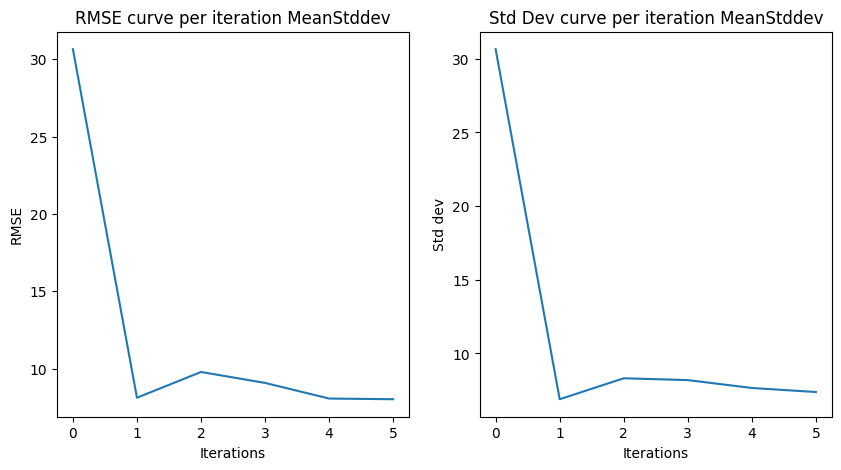

In [20]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.plot(MeanStddev_rmse)
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.title("RMSE curve per iteration MeanStddev")

plt.subplot(1,2,2)
plt.plot(MeanStddev_std)
plt.ylabel("Std dev")
plt.xlabel("Iterations")
plt.title("Std Dev curve per iteration MeanStddev")

plt.show()

### pNorm StdDev

In [21]:
from deepsensor.active_learning.acquisition_fns import pNormStddev

In [22]:

task_loader_train = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_train.load_dask()
print(task_loader_train)

print()

task_loader_val = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_val.load_dask()
print(task_loader_val)


# set up model 
model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))

# initializing train dates
train_dates = pd.date_range(train_range[0],train_range[1])[::2]
train_tasks = gen_tasks(train_dates,task_loader_train)

# initialzing val dates
# val_dates = pd.date_range(val_range[0], val_range[1])
val_dates = [pd.to_datetime(val_range[0])]
val_tasks = gen_tasks(val_dates,task_loader_val)

initial_rmse = compute_val_rmse(model,val_tasks)
initial_std = compute_std(model,val_tasks)

print(initial_rmse)
print(initial_std)

lat_long_pairs_current = lat_long_pairs.copy()
current_sensor_locations = Initial_sensor_locations.copy()

train_model(model,train_tasks,val_tasks)

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=land_mask_raw_ds,  # Mask out ocean from search points
    X_t_mask=land_mask_raw_ds,  # Mask out ocean from target points
    N_new_context=1,
    progress_bar=True,
)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)
dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

37.401207
42.68148


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Error 12.37 | std 12.17
Epoch 2 | Error 10.06 | std 9.74
Epoch 3 | Error 8.90 | std 8.86
Epoch 4 | Error 8.51 | std 7.60
Epoch 5 | Error 7.98 | std 8.09


In [23]:
vars = []
max_points_to_pick = 5
lat_long_pairs_current = lat_long_pairs.copy()

# initial_rmse = compute_val_rmse(model,val_tasks)
# initial_std = compute_std(model,val_tasks)

pNormStddev_rmse = [initial_rmse]
pNormStddev_std = [initial_rmse]

for iter in tqdm_notebook(range(max_points_to_pick)):

    acquisition_fn = pNormStddev(model)

    X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, val_tasks, diff= True)

    x1,x2 = X_new_df.to_numpy()[0]
    x1 = (x1-15)/100
    x2 = (x2+160)/100
    X_new_df  = pd.DataFrame([[x1,x2],],columns=['lat','lon'])

    lat_long_pairs_current = pd.DataFrame(np.concat([lat_long_pairs_current,X_new_df.to_numpy()]),columns=['x1','x2'])
    current_sensor_locations = pd.merge(era5_ds_df.reset_index(),lat_long_pairs_current, on =['x1','x2'],how='inner').set_index(['time','x1','x2'])

    model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))
    task_loader_current = TaskLoader(
    context=[current_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
        )
    task_loader_current.load_dask()
    train_tasks = gen_tasks(train_dates,task_loader_current)
    train_model(model,train_tasks)

    rmse = compute_val_rmse(model,val_tasks)
    std = compute_std(model,val_tasks)

    pNormStddev_rmse.append(rmse)
    pNormStddev_std.append(std)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:31<00:00,  2.11it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:38<00:00,  1.96it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:39<00:00,  1.93it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:39<00:00,  1.93it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:38<00:00,  1.96it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

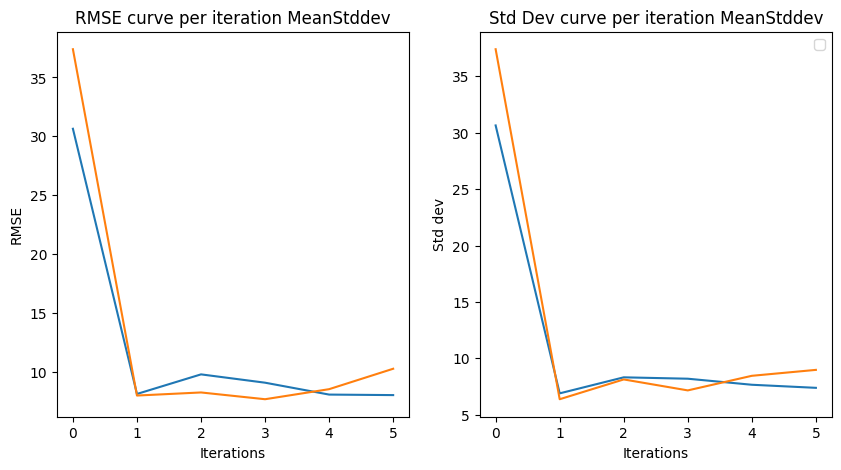

In [24]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.plot(MeanStddev_rmse, label="MeanStddev")
plt.plot(pNormStddev_rmse,label = "pNormStddev")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.title("RMSE curve per iteration MeanStddev")

plt.subplot(1,2,2)
plt.plot(MeanStddev_std)
plt.plot(pNormStddev_std)
plt.ylabel("Std dev")
plt.xlabel("Iterations")
plt.title("Std Dev curve per iteration MeanStddev")
plt.legend()

plt.show()

### 3. OracleMAE

In [25]:
from deepsensor.active_learning.acquisition_fns import OracleMAE

In [ ]:

task_loader_train = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_train.load_dask()
print(task_loader_train)

print()

task_loader_val = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_val.load_dask()
print(task_loader_val)


# set up model 
model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))

# initializing train dates
train_dates = pd.date_range(train_range[0],train_range[1])[::2]
train_tasks = gen_tasks(train_dates,task_loader_train)

# initialzing val dates
# val_dates = pd.date_range(val_range[0], val_range[1])
val_dates = [pd.to_datetime(val_range[0])]
val_tasks = gen_tasks(val_dates,task_loader_val)

initial_rmse = compute_val_rmse(model,val_tasks)
initial_std = compute_std(model,val_tasks)

print(initial_rmse)
print(initial_std)

lat_long_pairs_current = lat_long_pairs.copy()
current_sensor_locations = Initial_sensor_locations.copy()

train_model(model,train_tasks,val_tasks)

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=land_mask_raw_ds,  # Mask out ocean from search points
    X_t_mask=land_mask_raw_ds,  # Mask out ocean from target points
    N_new_context=1,
    progress_bar=True,
    task_loader=task_loader_train,
)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)
dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

45.016403
56.52115


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Error 13.29 | std 13.35
Epoch 2 | Error 11.19 | std 10.43
Epoch 3 | Error 9.66 | std 8.21
Epoch 4 | Error 8.83 | std 8.01
Epoch 5 | Error 9.18 | std 8.11


In [29]:
vars = []
max_points_to_pick = 5
lat_long_pairs_current = lat_long_pairs.copy()

# initial_rmse = compute_val_rmse(model,val_tasks)
# initial_std = compute_std(model,val_tasks)

OracleMAE_rmse = [initial_rmse]
OracleMAE_std = [initial_rmse]

for iter in tqdm_notebook(range(max_points_to_pick)):

    acquisition_fn = OracleMAE(model)

    X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, val_tasks, diff= True)

    x1,x2 = X_new_df.to_numpy()[0]
    x1 = (x1-15)/100
    x2 = (x2+160)/100
    X_new_df  = pd.DataFrame([[x1,x2],],columns=['lat','lon'])

    lat_long_pairs_current = pd.DataFrame(np.concat([lat_long_pairs_current,X_new_df.to_numpy()]),columns=['x1','x2'])
    current_sensor_locations = pd.merge(era5_ds_df.reset_index(),lat_long_pairs_current, on =['x1','x2'],how='inner').set_index(['time','x1','x2'])

    model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))
    task_loader_current = TaskLoader(
    context=[current_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
        )
    task_loader_current.load_dask()
    train_tasks = gen_tasks(train_dates,task_loader_current)
    train_model(model,train_tasks)

    rmse = compute_val_rmse(model,val_tasks)
    std = compute_std(model,val_tasks)

    OracleMAE_rmse.append(rmse)
    OracleMAE_std.append(std)


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:32<00:00,  2.08it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:37<00:00,  1.99it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:37<00:00,  1.97it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:38<00:00,  1.96it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [01:37<00:00,  1.99it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

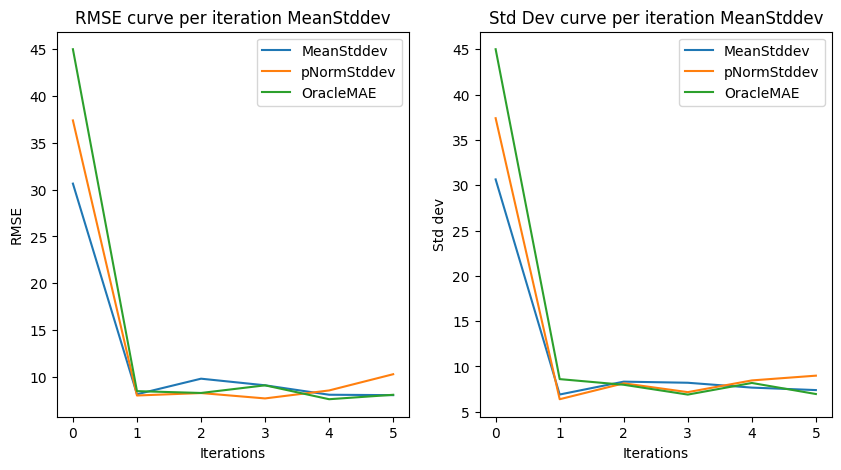

In [32]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.plot(MeanStddev_rmse, label="MeanStddev")
plt.plot(pNormStddev_rmse,label = "pNormStddev")
plt.plot(OracleMAE_rmse, label = "OracleMAE")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.title("RMSE curve per iteration MeanStddev")
plt.legend()

plt.subplot(1,2,2)
plt.plot(MeanStddev_std, label="MeanStddev")
plt.plot(pNormStddev_std, label = "pNormStddev")
plt.plot(OracleMAE_std, label = "OracleMAE")
plt.ylabel("Std dev")
plt.xlabel("Iterations")
plt.title("Std Dev curve per iteration MeanStddev")
plt.legend()

plt.show()

### Random

In [33]:
from deepsensor.active_learning.acquisition_fns import Random

In [34]:

task_loader_train = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_train.load_dask()
print(task_loader_train)

print()

task_loader_val = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_val.load_dask()
print(task_loader_val)


# set up model 
model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))

# initializing train dates
train_dates = pd.date_range(train_range[0],train_range[1])[::2]
train_tasks = gen_tasks(train_dates,task_loader_train)

# initialzing val dates
# val_dates = pd.date_range(val_range[0], val_range[1])
val_dates = [pd.to_datetime(val_range[0])]
val_tasks = gen_tasks(val_dates,task_loader_val)

initial_rmse = compute_val_rmse(model,val_tasks)
initial_std = compute_std(model,val_tasks)

print(initial_rmse)
print(initial_std)

lat_long_pairs_current = lat_long_pairs.copy()
current_sensor_locations = Initial_sensor_locations.copy()

train_model(model,train_tasks,val_tasks)

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=land_mask_raw_ds,  # Mask out ocean from search points
    X_t_mask=land_mask_raw_ds,  # Mask out ocean from target points
    N_new_context=1,
    progress_bar=True,
    task_loader=task_loader_train,
)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)
dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

53.94735
16.102566


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Error 13.57 | std 13.47
Epoch 2 | Error 11.40 | std 11.01
Epoch 3 | Error 9.68 | std 8.91
Epoch 4 | Error 8.38 | std 7.62
Epoch 5 | Error 8.96 | std 9.01


In [39]:
vars = []
max_points_to_pick = 5
lat_long_pairs_current = lat_long_pairs.copy()

# initial_rmse = compute_val_rmse(model,val_tasks)
# initial_std = compute_std(model,val_tasks)

Random_rmse = [initial_rmse]
Random_std = [initial_rmse]

for iter in tqdm_notebook(range(max_points_to_pick)):

    acquisition_fn = Random(model)

    X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, val_tasks)

    x1,x2 = X_new_df.to_numpy()[0]
    x1 = (x1-15)/100
    x2 = (x2+160)/100
    X_new_df  = pd.DataFrame([[x1,x2],],columns=['lat','lon'])

    lat_long_pairs_current = pd.DataFrame(np.concat([lat_long_pairs_current,X_new_df.to_numpy()]),columns=['x1','x2'])
    current_sensor_locations = pd.merge(era5_ds_df.reset_index(),lat_long_pairs_current, on =['x1','x2'],how='inner').set_index(['time','x1','x2'])

    model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))
    task_loader_current = TaskLoader(
    context=[current_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
        )
    task_loader_current.load_dask()
    train_tasks = gen_tasks(train_dates,task_loader_current)
    train_model(model,train_tasks)

    rmse = compute_val_rmse(model,val_tasks)
    std = compute_std(model,val_tasks)

    Random_rmse.append(rmse)
    Random_std.append(std)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 676.83it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 381.16it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 527.12it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 381.40it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 410.48it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

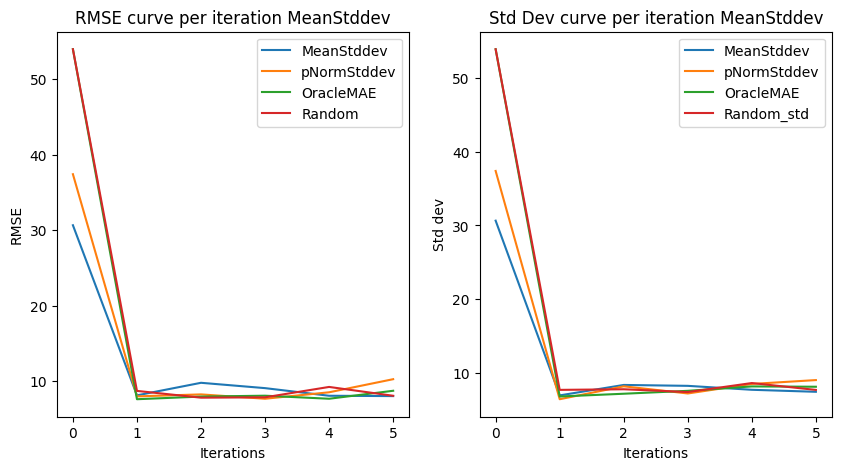

In [40]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.plot(MeanStddev_rmse, label="MeanStddev")
plt.plot(pNormStddev_rmse,label = "pNormStddev")
plt.plot(OracleMAE_rmse, label = "OracleMAE")
plt.plot(Random_rmse, label = "Random")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.title("RMSE curve per iteration MeanStddev")
plt.legend()

plt.subplot(1,2,2)
plt.plot(MeanStddev_std, label="MeanStddev")
plt.plot(pNormStddev_std, label = "pNormStddev")
plt.plot(OracleMAE_std, label = "OracleMAE")
plt.plot(Random_std, label = "Random_std")
plt.ylabel("Std dev")
plt.xlabel("Iterations")
plt.title("Std Dev curve per iteration MeanStddev")
plt.legend()

plt.show()

### Oracle marginal NLL

In [41]:
from deepsensor.active_learning.acquisition_fns import OracleMarginalNLL

In [42]:

task_loader_train = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_train.load_dask()
print(task_loader_train)

print()

task_loader_val = TaskLoader(
    context=[Initial_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
)
task_loader_val.load_dask()
print(task_loader_val)


# set up model 
model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))

# initializing train dates
train_dates = pd.date_range(train_range[0],train_range[1])[::2]
train_tasks = gen_tasks(train_dates,task_loader_train)

# initialzing val dates
# val_dates = pd.date_range(val_range[0], val_range[1])
val_dates = [pd.to_datetime(val_range[0])]
val_tasks = gen_tasks(val_dates,task_loader_val)

initial_rmse = compute_val_rmse(model,val_tasks)
initial_std = compute_std(model,val_tasks)

print(initial_rmse)
print(initial_std)

lat_long_pairs_current = lat_long_pairs.copy()
current_sensor_locations = Initial_sensor_locations.copy()

train_model(model,train_tasks,val_tasks)

greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=era5_raw_ds,
    X_s=era5_raw_ds.coarsen(lat=15, lon=15, boundary="trim").mean(),  # Coarsen search points to speed up computation
    X_s_mask=land_mask_raw_ds,  # Mask out ocean from search points
    X_t_mask=land_mask_raw_ds,  # Mask out ocean from target points
    N_new_context=1,
    progress_bar=True,
    task_loader=task_loader_train,
)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('2m_temperature',), ('GLDAS_mask',), ('elevation', 'cos_D', 'sin_D'))
Target variable IDs: (('2m_temperature',),)
dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

67.094826
57.074818


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Error 14.05 | std 12.79
Epoch 2 | Error 12.33 | std 12.57
Epoch 3 | Error 11.73 | std 12.08
Epoch 4 | Error 10.45 | std 10.51
Epoch 5 | Error 9.80 | std 8.98


In [43]:
vars = []
max_points_to_pick = 5
lat_long_pairs_current = lat_long_pairs.copy()

# initial_rmse = compute_val_rmse(model,val_tasks)
# initial_std = compute_std(model,val_tasks)

OracleMarginalNLL_rmse = [initial_rmse]
OracleMarginalNLL_std = [initial_rmse]

for iter in tqdm_notebook(range(max_points_to_pick)):

    acquisition_fn = OracleMarginalNLL(model)

    X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, val_tasks)

    x1,x2 = X_new_df.to_numpy()[0]
    x1 = (x1-15)/100
    x2 = (x2+160)/100
    X_new_df  = pd.DataFrame([[x1,x2],],columns=['lat','lon'])

    lat_long_pairs_current = pd.DataFrame(np.concat([lat_long_pairs_current,X_new_df.to_numpy()]),columns=['x1','x2'])
    current_sensor_locations = pd.merge(era5_ds_df.reset_index(),lat_long_pairs_current, on =['x1','x2'],how='inner').set_index(['time','x1','x2'])

    model = ConvNP(data_processor, task_loader_train, unet_channels = (32,32,32,32))
    task_loader_current = TaskLoader(
    context=[current_sensor_locations, land_mask_ds, lowres_aux_ds],
    target=era5_ds,
        )
    task_loader_current.load_dask()
    train_tasks = gen_tasks(train_dates,task_loader_current)
    train_model(model,train_tasks)

    rmse = compute_val_rmse(model,val_tasks)
    std = compute_std(model,val_tasks)

    OracleMarginalNLL_rmse.append(rmse)
    OracleMarginalNLL_std.append(std)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [03:06<00:00,  1.03it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [03:22<00:00,  1.05s/it]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [03:16<00:00,  1.02s/it]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [03:11<00:00,  1.01it/s]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 193/193 [03:16<00:00,  1.02s/it]


dim_yc inferred from TaskLoader: (1, 1, 3)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 400
encoder_scales inferred from TaskLoader: [0.00125, np.float32(0.00125), np.float32(0.0041666664)]
decoder_scale inferred from TaskLoader: 0.0025


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

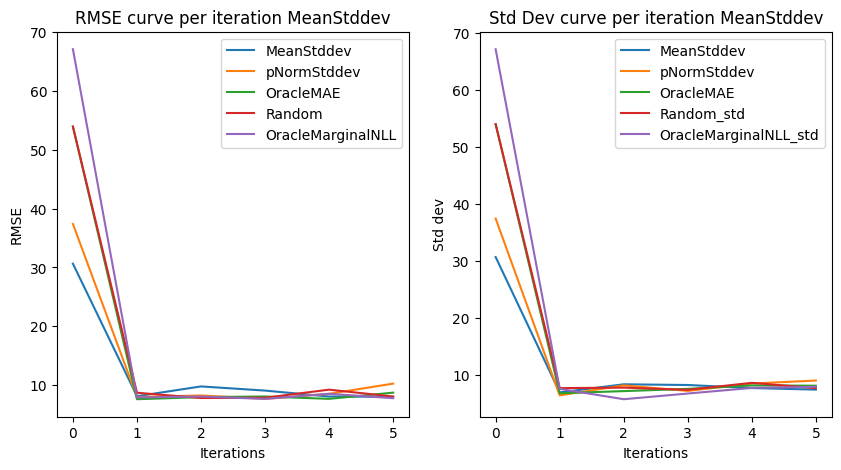

In [46]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.plot(MeanStddev_rmse, label="MeanStddev")
plt.plot(pNormStddev_rmse,label = "pNormStddev")
plt.plot(OracleMAE_rmse, label = "OracleMAE")
plt.plot(Random_rmse, label = "Random")
plt.plot(OracleMarginalNLL_rmse, label = "OracleMarginalNLL")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.title("RMSE curve per iteration MeanStddev")
#plt.ylim(0,10)
plt.legend()

plt.subplot(1,2,2)
plt.plot(MeanStddev_std, label="MeanStddev")
plt.plot(pNormStddev_std, label = "pNormStddev")
plt.plot(OracleMAE_std, label = "OracleMAE")
plt.plot(Random_std, label = "Random_std")
plt.plot(OracleMarginalNLL_std, label = "OracleMarginalNLL_std")
plt.ylabel("Std dev")
plt.xlabel("Iterations")
plt.title("Std Dev curve per iteration MeanStddev")
#plt.ylim(0,10)
plt.legend()

plt.show()